# **Loading important libraries**

In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

Using TensorFlow backend.


# **utility functions for loss and create pairs**

In [0]:
#function to calculate euclidean distance between two vectors produce by base network
def euclidean_distance(vects): #'vects' variable contains two vectors from  base network
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

#function to set output shape of final concatenated model
def eucl_dist_output_shape(shapes): #'shapes' parameter Contains shapes of two resultant vector
    shape1, shape2 = shapes
    return (shape1[0], 1)

#custom function to compute accuracy of the network
def compute_accuracy(y_true, y_pred): #y_true is ground labels of pairs while y_pred is the predicted value of 
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))
  
  
#Function Create pairs makes pair of data images according to labels the data have
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    num_classes = int(len(digit_indices))
    
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)
  

#function to plot pair of images and their corresponding model predicted and ground truth 
def plotfigures_data(index,y_pred,data,gt_labels): #'index' is index of image pair number, 'y_pred' model prediction, 'data' is dataset, 'gt_labels' ground truth labels

  labelname = ['similar','different'] 
  fig = plt.figure()
  ax1 = fig.add_subplot(2,2,1)
  pred = 'similar' if y_pred[index] < 0.5 else 'different'
  ground = 'similar' if gt_labels[index] == 1 else 'different'

  #printing mdoel prediction along with ground label and model confidence score
  #print('Model prediction Confidence: ',y_pred[index])
  print('Ground label: ', ground)
  print('Model  prediction: ',pred)
  ax1.imshow(data[index,0].reshape((28,28)))
  ax2 = fig.add_subplot(2,2,2)
  ax2.imshow(data[index,1].reshape((28,28)))
  plt.show()


# **Loading Fashion Mnist data**

In [76]:
from keras.datasets import fashion_mnist
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()

#Concatenating into one dataset into variable 'finaldata', so that we can split it into train and test based on our own condition.
finaldata = np.concatenate((trainX,testX),axis = 0)
finallabels = np.concatenate((trainY,testY),axis = 0)
finaldata = np.expand_dims(finaldata,axis=3)

#printing shape of finaldata set
print('Dataset Shape: ',finaldata.shape)
print('Dataset labels Shape: ',finallabels.shape)

Dataset Shape:  (70000, 28, 28, 1)
Dataset labels Shape:  (70000,)


# **Now We split the data into test and train based on labels**

In [160]:
#labels with their corresponding numeric labels
#T-shirt/top : 0 , Trouser/pants : 1 , Pullover shirt: 2 ,  Dress: 3 , Coat: 4 ,  Sandal: 5 , Shirt: 6, Sneaker:7 , Bag: 8 , Ankle boot:9

#These are test and train numeric labels 
trainlabels = [0,1,2,4,5,9] # "top", "trouser", "pullover", "coat", "sandal", "ankle
testlabels = [3,6,7,8] #"dress", "sneaker", "bag", "shirt"

#finding indices of train and test labels
trainlabels_indices = [np.where(finallabels == i)[0] for i in trainlabels]
testlabels_indices = [np.where(finallabels == i)[0] for i in testlabels]


#now dividing training set further into trainable and validation set. we take 20% of the train set into validation set.
vallabels_indices = []
for i in range(len(trainlabels_indices)):
  vallabels_indices.append(trainlabels_indices[i][-1400:])
  trainlabels_indices[i] = trainlabels_indices[i][:-1400]

print(np.array(trainlabels_indices).shape)
print(np.array(vallabels_indices).shape)

(6, 5600)
(6, 1400)


In [161]:
#Now making pairs of train and test data based on seperate labels
train_pairs, train_y = create_pairs(finaldata, trainlabels_indices)
val_pairs,val_y = create_pairs(finaldata, vallabels_indices)
test_pairs, test_y = create_pairs(finaldata, testlabels_indices)

#printing shape of test and train Data
print('Training Dataset Shape: ',train_pairs.shape,train_y.shape)
print('Validation Dataset Shape: ',val_pairs.shape,val_y.shape)
print('Testing Dataset Shape: ',test_pairs.shape,test_y.shape)

Training Dataset Shape:  (67188, 2, 28, 28, 1) (67188,)
Validation Dataset Shape:  (16788, 2, 28, 28, 1) (16788,)
Testing Dataset Shape:  (55992, 2, 28, 28, 1) (55992,)


Now we normalize images pixel values between 0 and 1 because to make model learn these images it is necessary to scale the images in general range.

In [0]:
#normalizaing Data
train_pairs = train_pairs.astype('float32')
val_pairs = val_pairs.astype('float32')
test_pairs = test_pairs.astype('float32')
train_pairs /= 255
val_pairs /= 255
test_pairs /= 255

# **Now We declare our custom Loss function which is Contrast function and build it**

In [0]:
#Loss function
def contrastive_loss(y_true, y_pred):
    #Contrastive loss function
    
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# **Building Base network that gives us final feature vector learned from pair of images**

In [0]:

def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
  
    
    input = Input(shape=input_shape)
    x = keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu')(input)
    x = Dropout(0.3)(x)
    #x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, kernel_size=(3, 3),activation='relu')(x)
    x = Dropout(0.4)(x)
    #x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Conv2D(128, kernel_size=(3, 3),activation='relu')(x)
    x = keras.layers.Flatten()(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)#activity_regularizer=regularizers.l1(0.001))(x)
    return Model(input, x)


# **Now we build siamese model**

In [0]:
import warnings
warnings.filterwarnings("ignore")

from keras import optimizers
from keras import regularizers


input_shape = train_pairs.shape[2:]

#Creating base network definition
base_network = create_base_network(input_shape) #input_shape avriable is input shape of the model 28*28*1 .

#Declaring shape for base network instances
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

#Concatenating two base model instances to make its output to one model
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

#Declaring one final model
model = Model([input_a, input_b], distance)

# Declaring optimizer and compiling model to build it
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=contrastive_loss, optimizer=sgd, metrics=[accuracy])

# **Training**

In [131]:
import warnings
warnings.filterwarnings("ignore")

epochs = 5
#training of model
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
          batch_size=256,
          epochs=epochs,
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Train on 67188 samples, validate on 16788 samples
Epoch 1/5
67188/67188 [==============================] - 24s 362us/step - loss: 0.2503 - accuracy: 0.5430 - val_loss: 0.2671 - val_accuracy: 0.5262
Epoch 2/5
67188/67188 [==============================] - 23s 346us/step - loss: 0.1817 - accuracy: 0.7457 - val_loss: 0.1251 - val_accuracy: 0.8335
Epoch 3/5
67188/67188 [==============================] - 23s 345us/step - loss: 0.1273 - accuracy: 0.8473 - val_loss: 0.1019 - val_accuracy: 0.8675
Epoch 4/5
67188/67188 [==============================] - 23s 345us/step - loss: 0.1093 - accuracy: 0.8696 - val_loss: 0.0913 - val_accuracy: 0.8803
Epoch 5/5
67188/67188 [==============================] - 23s 345us/step - loss: 0.1000 - accuracy: 0.8809 - val_loss: 0.0844 - val_accuracy: 0.8865


We only train out model for 5 epochs as if we train more model starts to learn noise which does not give give generalization capacity to our model.

# **Plotting loss and Accuracy curve of train and validation data**

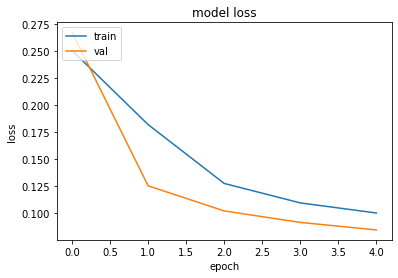

In [132]:
#Loss curve shows loss is reducing over time on bth dataset validation and training
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

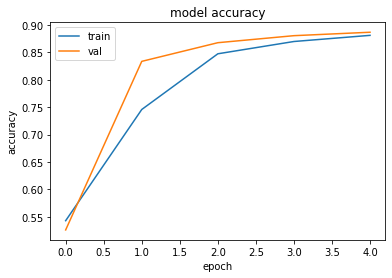

In [133]:
# Accuracy curve to show accuracy is increasing of both datasets.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# **Testing To see Generalization capacity**

###1) First we test generalization capacity on pairs of images corresponding to labels s ["top", "trouser", "pullover", "coat","sandal", "ankle boot"]

In [150]:
# compute final accuracy on validation set which consist of data corresponding to labels ["top", "trouser", "pullover", "coat", "sandal", "ankle boot"]
#Quantitative Results
y_pred = model.predict([val_pairs[:, 0], val_pairs[:, 1]])
tr_acc = compute_accuracy(val_y, y_pred)
print('* Accuracy on Validation set: %0.2f%%' % (100 * tr_acc))

* Accuracy on Validation set: 88.65%


Ground label:  similar
Model  prediction:  similar


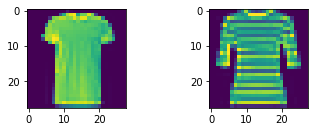

In [151]:
#here change the index variable to get different types of pairs of images and their model prediction
index = 8
plotfigures_data(index,y_pred,train_pairs,train_y)

### 2) Now we test generalization capacity on data which corresponds to labels  ["dress", "sneaker", "bag", "shirt"]

In [152]:
#As we know the the daat corresponding to the above mentioned labels is placed in test_pairs variable
y_pred = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
te_acc = compute_accuracy(test_y, y_pred)
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on test set: 81.73%


Ground label:  different
Model  prediction:  different


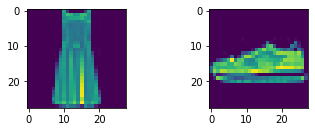

In [154]:
#here change the index variable to get different types of pairs of images and their model prediction
index = 7
plotfigures_data(index,y_pred,test_pairs,test_y)

###3) Now we show generalization capacity of our model on pairs of images corresponding to labels  ["top", "trouser", "pullover", "coat","sandal", "ankle boot"] union ["dress", "sneaker", "bag", "shirt"]

In [164]:
union_indices = testlabels_indices.copy()

#We first concatenate indices of validation data and testing data to get pair of images of both dataset.
for i in range(len(vallabels_indices)):
  union_indices.append(vallabels_indices[i])

#Creating pairs of union data
union_pairs,union_y = create_pairs(finaldata, union_indices)
union_pairs = union_pairs.astype('float32')
union_pairs /= 255
print(union_pairs.shape)
print(union_y.shape)

(27980, 2, 28, 28, 1)
(27980,)


In [165]:
#As we know the the data corresponding to the above mentioned labels is placed in union pairs variable
y_pred = model.predict([union_pairs[:, 0], union_pairs[:, 1]])
union_acc = compute_accuracy(union_y, y_pred)
print('* Accuracy on union test set: %0.2f%%' % (100 * union_acc))

* Accuracy on union test set: 83.41%


Ground label:  similar
Model  prediction:  similar


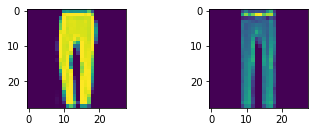

In [179]:
index = 15000
plotfigures_data(index,y_pred,union_pairs,union_y)